In [1]:
import csv
from datetime import datetime, timedelta
import string
import pymorphy2
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.stem import SnowballStemmer
import pandas as pd
from tqdm import tqdm
import matplotlib
day_offset = 0
DISABLE_MULTITOKEN = True

# Предварительные настройки
stop_words = stopwords.words("russian")  # nltk загрузка стоп-слов
# snowball = SnowballStemmer(language="russian")  # nltk стемматизатор
morph = pymorphy2.MorphAnalyzer(lang='ru')  # Морфический анализатор

In [2]:
def tokenizer(text):
    result = []
    for element in sent_tokenize(text, language="russian"):  # Токенизация предложения
        tokens = word_tokenize(element, language="russian")  # Токенизация слов
        result_tokens = []
        tokens = [''.join(c for c in s if c not in string.punctuation) for s in tokens]  # удаляем знаки препинания
        tokens = [''.join(c for c in s if c not in string.octdigits) for s in tokens]  # удаляем цифры
        tokens = [s for s in tokens if s]  # удаляем пустые элементы
        for token in tokens:
            if token not in stop_words and token != "—" and token != "–":  # удаление стоп-слов и дефисов
                token = morph.parse(token)[0].normal_form  # Нормализация
                # token = snowball.stem(token)  # Стемматизация
                result_tokens.append(token)
        if DISABLE_MULTITOKEN:
            result += result_tokens
        else:
            result.append(result_tokens)
    #  print(result)
    return result

In [3]:
def news_reader(filename):
    with open(filename, encoding='utf-8') as news_file:
        result = []
        spamreader = csv.reader(news_file)
        for row in spamreader:
            if row:
                date_ = (datetime.strptime(row[-1],
                         '%Y-%m-%d %H:%M:%S').date() - timedelta(days=day_offset)).strftime("%d-%m-%Y")
                # print(date, row[1])
                result.append([date_, row[1]])
    return result

In [4]:
def eco_reader(filename):
    with open(filename, encoding='utf-8') as emo_file:
        result = {}
        spamreader = csv.reader(emo_file, delimiter=';')
        for row in spamreader:
            if row:
                token = tokenizer(row[0])
                if type(token) == list and len(token) > 0:
                    result[token[0]] = [row[1], row[2], row[3], row[4], row[5], row[6], row[7]]
    return result

In [5]:
def get_sentence_color(sentence):
    wtot = 0
    wpos = 0
    wneg = 0
    for word in sentence:
        wtot = wtot + 1
        if word in emo_dict:
            if float(emo_dict[word][1]) > 0:
                wpos = wpos + 1
            else:
                wneg = wneg + 1
    return (wpos-wneg)/wtot

In [6]:
news_list = news_reader('ria.csv')
emo_dict = eco_reader('emo_dict.csv')

In [7]:
output = []
result_list = []
# news_temp = news_list[:500]
for news in tqdm(news_list):
    tokened_news = tokenizer(news[1])
    vector = []

    sum_vector = get_sentence_color(tokened_news)
    
    result = f'{news[0]};{news[1]};{tokened_news};{vector};{sum_vector}\n'
    result_list.append([news[0], news[1], tokened_news, vector, sum_vector])
    output.append(result)

100%|█████████████████████████████████████████████████████████████████████| 285117/285117 [09:44<00:00, 487.74it/s]


In [8]:
with open("result.csv", "w+", encoding="utf-8") as result_file:
    for result in output:
        result_file.write(result)

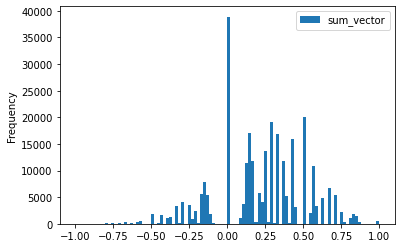

In [9]:
df = pd.DataFrame(result_list, columns=["date", "text", "tokened_text", "vector", "sum_vector"])
ax = df.plot.hist(by='sum_vector', bins=100)